# <img style="float: left; padding-right: 10px; width: 45px" src="fig/iacs.png"> S-109A Introduction to Data Science 
## Homework 4 - Regularization 



**Harvard University**<br/>
**Summer 2018**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader

<hr style="height:2pt">

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

Names of people you have worked with goes here: 

<hr style="height:2pt">

In [1]:
from IPython.core.display import HTML
def css_styling(): styles = open("cs109.css", "r").read(); return HTML(styles)
css_styling()

import these libraries

In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold

#import statsmodels.api as sm

from pandas.core import datetools
%matplotlib inline

# Continuing Bike Sharing Usage Data

In this homework, we will focus on regularization and cross validation. We will continue to build regression models for the Capital Bikeshare program in Washington D.C.  See homework 3 for more information about the Capital Bikeshare data that we'll be using extensively. 



## Data Preparation



<div class='exercise'> <b> Question 1 </b> </div> 
  In HW3 Questions 1-3, you preprocessed the data in preparation for your regression analysis. We ask you to repeat those steps (particularly those in Question 3) so that we can compare the analysis models in this HW with those you developed in HW3.  In this HW we'll be using models from sklearn exclusively (as opposed to statsmodels)
  
**1.1** [From HW3] Read `data/BSS_train.csv` and `data/BSS_test.csv` into dataframes `BSS_train` and `BSS_test`, respectively.  Remove the `dteday` column from both train and test dataset. We do not need it, and its format cannot be used for analysis.  Also remove the `casual` and `registered` columns for both training and test datasets as they make  `count` trivial.   

**1.2** Since we'll be exploring Regularization and Polynomial Features, it will make sense to standardize our data.  Standardize the numerical features. Store the dataframes for the processed training and test predictors into the variables `X_train` and `X_test`.  Store the appropriately shaped numpy arrays for the corresponding train and test `count` columns into `y_train` and `y_test`.

**1.3** Use the `LinearRegression` library from `sklearn` to fit a multiple linear regression model to the training set data in `X_train`.  Store the fitted model in the variable `BikeOLSModel`.

**1.4** What are the training and test set $R^2$ scores?  Store the training and test $R^2$ scores of the `BikeOLSModel` in a dictionary `BikeOLS_r2scores` using the string 'training' and 'test' as keys.  

**1.5**   We're going to use bootstrapped confidence intervals (use 500 bootstrap iterations) to determine which of the estimated coefficients for the `BikeOLSModel` are statistically significant at a significance level of 5% .  We'll do so by creating 3 different functions:

1. `make_bootstrap_sample(dataset_X, dataset_y)` returns a bootstrap sample of `dataset_X` and `dataset_y`
2. `calculate_coefficients(dataset_X, dataset_y, model)` returns in the form of a dictionary regression coefficients calculated by your model on `dataset_X` and `dataset_y`.  The keys for regression coefficients dictionary should be the names of the features.  The values should be the coefficient values of that feature calculated on your model.  An example would be {'hum': 12.3, 'windspeed': -1.2, 'Sunday': 0.6 ... }
3. `get_significant_predictors(regression_coefficients, significance_level)` takes as input a list of regression coefficient dictionaries (each one the output of `calculate_coefficients` and  returns a python list of the feature names of the significant predictors e.g. ['Monday', 'hum', 'holiday', ... ]

In the above functions `dataset_X` should always be a pandas dataframe with your features, `dataset_y` a numpy column vector with the values of the response variable and collectively they form the dataset upon which the operations take place. `model` is the `sklearn` regression model that will be used to generate the regression coefficients. `regression_coefficients` is a list of dictionaries of numpy arrays with each numpy array containing the regression coefficients (not including the intercept) calculated from one bootstrap sample.  `significance_level` represents the significance level as a floating point number.  So a 5% significance level should be represented as 0.05.  


Store the feature names as a list of strings in the variable `BikeOLS_significant_bootstrap` and print them for your answer.


### Answers

#### 1.1 Read `data/BSS_train.csv` and `data/BSS_test.csv` into Pandas DataFrames

In [3]:
BSS_train = pd.read_csv('data/BSS_train.csv', index_col = 0)
BSS_test= pd.read_csv('data/BSS_test.csv', index_col = 0)

In [4]:
BSS_train.head()

,dteday,hour,holiday,year,workingday,temp,atemp,hum,windspeed,casual,...,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
0,2011-01-01,0,0,0,0,0.24,0.2879,0.81,0.0,3,...,0,0,0,0,0,0,1,0,0,0
1,2011-01-01,1,0,0,0,0.22,0.2727,0.80,0.0,8,...,0,0,0,0,0,0,1,0,0,0
2,2011-01-01,2,0,0,0,0.22,0.2727,0.80,0.0,5,...,0,0,0,0,0,0,1,0,0,0
3,2011-01-01,3,0,0,0,0.24,0.2879,0.75,0.0,3,...,0,0,0,0,0,0,1,0,0,0
4,2011-01-01,4,0,0,0,0.24,0.2879,0.75,0.0,0,...,0,0,0,0,0,0,1,0,0,0


In [5]:
BSS_test.head()

,dteday,hour,holiday,year,workingday,temp,atemp,hum,windspeed,casual,...,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
6,2011-01-01,6,0,0,0,0.22,0.2727,0.80,0.0000,2,...,0,0,0,0,0,0,1,0,0,0
9,2011-01-01,9,0,0,0,0.32,0.3485,0.76,0.0000,8,...,0,0,0,0,0,0,1,0,0,0
20,2011-01-01,20,0,0,0,0.40,0.4091,0.87,0.2537,11,...,0,0,0,0,0,0,1,1,0,0
33,2011-01-02,10,0,0,0,0.36,0.3485,0.81,0.2239,7,...,0,0,0,0,0,0,0,1,0,0
35,2011-01-02,12,0,0,0,0.36,0.3333,0.66,0.2985,20,...,0,0,0,0,0,0,0,1,0,0


In [6]:
BSS_train = BSS_train.drop(['dteday', 'casual', 'registered'], axis = 1)
BSS_test = BSS_test.drop(['dteday', 'casual', 'registered'], axis = 1)

#### 1.2 Standardizing our data

In [7]:
# store copy of original dataframe
BSS_train_copy = BSS_train.copy()
BSS_test_copy = BSS_test.copy()

In [8]:
scaler = StandardScaler().fit(BSS_train[['temp', 'atemp', 'hum', 'windspeed']])
BSS_train[['temp', 'atemp', 'hum', 'windspeed']] = scaler.transform(BSS_train[['temp', 'atemp', 
                                                                                   'hum', 'windspeed']])
BSS_train.head()

,hour,holiday,year,workingday,temp,atemp,hum,windspeed,counts,spring,...,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
0,0,0,0,0,-1.332339,-1.090615,0.937108,-1.557515,16,0,...,0,0,0,0,0,0,1,0,0,0
1,1,0,0,0,-1.436131,-1.179015,0.885320,-1.557515,40,0,...,0,0,0,0,0,0,1,0,0,0
2,2,0,0,0,-1.436131,-1.179015,0.885320,-1.557515,32,0,...,0,0,0,0,0,0,1,0,0,0
3,3,0,0,0,-1.332339,-1.090615,0.626377,-1.557515,13,0,...,0,0,0,0,0,0,1,0,0,0
4,4,0,0,0,-1.332339,-1.090615,0.626377,-1.557515,1,0,...,0,0,0,0,0,0,1,0,0,0


In [9]:
BSS_test[['temp', 'atemp', 'hum', 'windspeed']] = scaler.transform(BSS_test[['temp', 'atemp', 
                                                                                   'hum', 'windspeed']])
BSS_test.head()

,hour,holiday,year,workingday,temp,atemp,hum,windspeed,counts,spring,...,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
6,6,0,0,0,-1.436131,-1.179015,0.885320,-1.557515,2,0,...,0,0,0,0,0,0,1,0,0,0
9,9,0,0,0,-0.917170,-0.738176,0.678165,-1.557515,14,0,...,0,0,0,0,0,0,1,0,0,0
20,20,0,0,0,-0.502000,-0.385738,1.247840,0.521907,36,0,...,0,0,0,0,0,0,1,1,0,0
33,10,0,0,0,-0.709585,-0.738176,0.937108,0.277655,53,0,...,0,0,0,0,0,0,0,1,0,0
35,12,0,0,0,-0.709585,-0.826577,0.160279,0.889105,93,0,...,0,0,0,0,0,0,0,1,0,0


In [10]:
X_train = BSS_train.drop('counts', axis = 1)
X_test = BSS_test.drop('counts', axis = 1)
y_train = BSS_train[['counts']].copy().values.reshape(-1,1)
y_test = BSS_test[['counts']].copy().values.reshape(-1,1)

#### 1.3 Use the `LinearRegression` library from `sklearn` to fit a multiple linear regression.

In [11]:
BikeOLSModel = LinearRegression().fit(X_train, y_train)

#### 1.4 What are the training and test set $R^2$ scores? Store the $R^2$ scores of the `BikeOLSModel` on the training and test sets in a dictionary `BikeOLS_r2scores`. 

In [12]:
prediction_train = BikeOLSModel.predict(X_train)
prediction_test = BikeOLSModel.predict(X_test)
r2_train_OLS = r2_score(y_train, prediction_train)
r2_test_OLS = r2_score(y_test, prediction_test)
print('Training R^2 score: {0:6f}'.format(r2_train_OLS))
print('Test R^2 score: {0:6f}'.format(r2_test_OLS))

Training R^2 score: 0.406539
Test R^2 score: 0.406386


In [13]:
BikeOLS_r2scores = {'r2_training': r2_train_OLS, 'r2_test': r2_test_OLS}  

<HR>
Your answer here
<HR>

#### 1.5 We're going to use bootstrapped confidence intervals to determine which of the estimated coefficients ...

In [14]:
# dataset_x should be a pandas dataframe

## accepts dataset inputs as numpy arrays
def make_bootstrap_sample(dataset_X, dataset_y, size = None) -> tuple:
    '''Take training dataset features and target, return bootstrapped datasets
    Args:
        dataset_X: training dataset features; dataset_y = training dataset target
    Returns:
        tuple of boostrapped training features as a pandas dataframe 
        and bootstrapped training target as a numpy array
    '''
    # by default return a bootstrap sample of the same size as the original dataset
    if not size: size = len(dataset_X)
    
    # if the X and y datasets aren't the same size, raise an exception
    if len(dataset_X) != len(dataset_y):
        raise Exception("Data size must match between dataset_X and dataset_y")

    inds_to_sample = (np.random.choice(dataset_X.shape[0], size = size, replace = True))
    bootstrap_dataset_X = dataset_X.iloc[inds_to_sample]
    bootstrap_dataset_y = dataset_y[inds_to_sample]
    
    return (bootstrap_dataset_X, bootstrap_dataset_y) 


def calculate_coefficients(dataset_X, dataset_y, model) -> list:
    '''Take bootstrapped training dataset features and target and return lin reg coefficients
    Args:
         dataset_X: pandas dataframe, dataset_y: numpy array, model to fit
    Return:
        dictionary containing bootstrap feature coefficients
    '''
    keys = tuple(X_train.columns.values)
    bootstrap_model = model.fit(dataset_X, dataset_y)
    coefficients_dictionary = dict(zip(keys, bootstrap_model.coef_[0]))
    return coefficients_dictionary

def get_significant_predictors(regression_coefficients, significance_level):
    '''Take list of regression coefficient dictionaries and return significant features
    Args:
        regression_coefficients: list of dictionaries
        significance_level: percent at which your testing for statistical significant (eg 5% input as 5)
    Returns:
        list of significant features
    '''
    keys = regression_coefficients[0].keys()
    significant_coefficients = []
    values_intervals = [] # return confidence intervals (as a check)
    for i, key in enumerate(keys):     
        values = [line[key] for line in regression_coefficients]
        # 5% significance level is equal to a lower limit percentile of 2.5% and an upper limit of 97.5%
        lower_limit, upper_limit = np.percentile(values, 
                                                 [significance_level/2, 100-significance_level/2])
        if not lower_limit <= 0 <= upper_limit:
            significant_coefficients.append(key)
            values_intervals.append([lower_limit, upper_limit])
        else:
            pass
    # return the significant coefficients as a list of strings
    return significant_coefficients, values_intervals

In [15]:
N = 1000
regression_coefficients = []
for i in range(N):
    bootstrap_dataset_X, bootstrap_dataset_y = make_bootstrap_sample(X_train, y_train)
    coef_dict = calculate_coefficients(bootstrap_dataset_X, bootstrap_dataset_y, LinearRegression())
    regression_coefficients.append(coef_dict)

In [16]:
BikeOLS_significant_bootstrap, conf_intervals = get_significant_predictors(regression_coefficients, 5)
BikeOLS_significant_bootstrap

['hour',
 'holiday',
 'year',
 'workingday',
 'temp',
 'hum',
 'windspeed',
 'spring',
 'summer',
 'fall',
 'Mar',
 'Apr',
 'May',
 'Jun',
 'Jul',
 'Aug',
 'Nov',
 'Sat',
 'Cloudy',
 'Snow']

In [17]:
conf_intervals

[[6.925782240574084, 7.567950731153229],
 [-28.819560960410453, -7.489990056490692],
 [71.7329548068986, 81.28248910525508],
 [6.296216303967614, 16.046875391702482],
 [44.66547857998237, 83.26181356900703],
 [-42.715073715676155, -36.764843996801325],
 [0.2017320726718477, 5.383094233403411],
 [29.780061326239736, 57.216175239046834],
 [11.699995651322386, 47.08379267034085],
 [56.09184968777388, 80.51755494997653],
 [-21.625270438699307, -1.2170034348772307],
 [-60.23283611521419, -23.61711383486511],
 [-54.20035896908734, -13.084339257021972],
 [-86.82993533526708, -44.75668776741995],
 [-117.68457896567271, -68.55141487609228],
 [-84.00048348493569, -36.67782806057482],
 [-41.09204557560979, -9.333612341623509],
 [7.276111106273726, 22.391800722060037],
 [0.9286142236440876, 12.717213120851502],
 [-37.09466132136804, -19.514780188663078]]

None of the corresponding confidence intervals contain 0, so all of the returned predictors are significant.

## Penalization Methods

In HW 3 Question 5 we explored using subset selection to find a significant subset of features.  We then fit a regression model just on that subset of features instead of on the full dataset (including all features).   As an alternative to selecting a subset of predictors and fitting a regression model on the subset, one can fit a linear regression model on all predictors, but shrink or regularize the coefficient estimates to make sure that the model does not "overfit" the training set. 

<div class='exercise'> <b> Question 2 </b> </div> 
  We're going to use Ridge and Lasso regression regularization techniques to fit linear models to the training set.  We'll use cross-validation and shrinkage parameters $\lambda$ from the set $\{.001,.005,1,5,10,50,100,500,1000\}$ to pick the best model for each regularization technique.

**2.1** Use 5-fold cross-validation to pick the best shrinkage parameter from the set $\{.001,.005,1,5,10,50,100,500,1000\}$ for your Ridge Regression model on the training data.  Fit a Ridge Regression model on the training set with the selected shrinkage parameter and store your fitted model in the variable `BikeRRModel`.  Store the selected shrinkage parameter in the variable `BikeRR_shrinkage_parameter`.

**2.2** Use 5-fold cross-validation to pick the best shrinkage parameter from the set $\{.001,.005,1,5,10,50,100,500,1000\}$ for your Lasso Regression model on the training data.  Fit a Lasso Regression model on the training set with the selected shrinkage parameter and store your fitted model in the variable `BikeLRModel`.  Store the selected shrinkage parameter in the variable `BikeLR_shrinkage_parameter`.

**2.3** Create three dictionaries `BikeOLSparams`, `BikeLRparams`, and `BikeRRparams`.  Store in each the corresponding regression coefficients for each of the regression models indexed by the string feature name.

**2.4** For the Lasso and Ridge Regression models list the features that are assigned a coefficient value close to 0 (i.e. the absolute value of the coefficient is less than 0.1).  How closely do they match the redundant predictors found (if any) in HW 3, Question 5?

**2.5** To get a visual sense of how the features different regression models (Multiple Linear Regression, Ridge Regression, Lasso Regression) estimate coefficients, order the features by magnitude of the estimated coefficients in the Multiple Linear Regression Model (no shrinkage).  Plot a bar graph of the magnitude (absolute value) of the estimated coefficients from Multiple Linear Regression in order from greatest to least.  Using a different color (and alpha values) overlay bar graphs of the magnitude of the estimated coefficients (in the same order as the Multiple Linear Regression coefficients) from Ridge and Lasso Regression.

**2.6** Let's examine a pair of features we believe to be related.  Is there a difference in the way Ridge and Lasso regression assign coefficients to the predictors `temp` and `atemp`? If so, explain the reason for the difference.

**2.7** Discuss the Results:

1. How do the estimated coefficients compare to or differ from the coefficients estimated by a plain linear regression (without shrinkage penalty) in Question 1? 
2. Is there a difference between coefficients estimated by the two shrinkage methods? If so, give an explantion for the difference.
3. Is the significance related to the shrinkage in some way?

*Hint:* You may use `sklearn`'s `RidgeCV` and `LassoCV` classes to implement Ridge and Lasso regression. These classes automatically perform cross-validation to tune the parameter $\lambda$ from a given range of values.

### Answers

In [18]:
lambdas = [.001, .005, 1, 5, 10, 50, 100, 500, 1000]

#### 2.1 Use 5-fold cross-validation to pick the best shrinkage parameter from the set $\{.001,.005,1,5,10,50,100,500,1000\}$ for your Ridge Regression model.

In [19]:
BikeRRModel = RidgeCV(alphas = lambdas, cv = 5).fit(X_train, y_train)
BikeRR_shrinkage_parameter = BikeRRModel.alpha_
BikeRR_shrinkage_parameter

500

#### 2.2 Use 5-fold cross-validation to pick the best shrinkage parameter from the set $\{.001,.005,1,5,10,50,100,500,1000\}$ for your Lasso Regression model.

In [20]:
BikeLRModel = LassoCV(alphas = lambdas, cv = 5).fit(X_train, y_train)
BikeLR_shrinkage_parameter = BikeLRModel.alpha_
BikeLR_shrinkage_parameter

0.005

#### 2.3 Create three dictionaries `BikeOLSparams`, `BikeLRparams`, and `BikeRRparams`.  Store in each the corresponding regression coefficients.

In [21]:
keys = tuple(X_train.columns.values)
BikeOLSparams = dict(zip(keys, BikeOLSModel.coef_[0]))
BikeLRparams = dict(zip(keys, BikeLRModel.coef_))
BikeRRparams = dict(zip(keys, BikeRRModel.coef_[0]))

#### 2.4 For the Lasso and Ridge Regression models list the features that are assigned a coefficient value close to 0 ...

<HR>
Your answer here
<HR>

In [22]:
def coef_zero(param_dict) -> list:
    '''Take dictionary of parameters and their coefficients, return parameters with coef close to zero
    Args: 
        params: dictionary of parameters and corresponding coefficients
    Returns:
        list of parameters whose coefficients are close to zero (ie absolute value < 0.1)
    '''
    coef_close_zero = []
    values_coef = [] # check values
    for key, value in param_dict.items():     
        if np.absolute(value) < 0.1:
            coef_close_zero.append(key)
            values_coef.append(value)
        else:
            pass
    return (coef_close_zero, values_coef)

In [23]:
RR_coef_zero, RR_coef_values = coef_zero(BikeRRparams)
print(RR_coef_zero)
RR_coef_values

[]


[]

In [24]:
LR_coef_zero, LR_coef_values = coef_zero(BikeLRparams)
print(LR_coef_zero)
LR_coef_values

['Mon']


[-0.0]

In HW 3, the redundant predictors from backward stepwise were:
{'Nov', 'holiday', 'summer', 'const', 'May', 'windspeed', 'Apr', 'Cloudy'}.
The redundant predictor from forward stepwise were:
{'workingday', 'Sat', 'Nov', 'summer', 'const', 'May', 'windspeed', 'Apr', 'Cloudy'}.

Only the Lasso model has a coefficient close to zero: Monday, with a value of zero. As you can see, this is in neither of the redundant predictors lists mentioned above, so it doesn't match at all. 

The Ridge model doesn't have any coefficients close to zero. This makes sense because while increasing the value of the shrinkage parameter tends to decrease the magnitude of the coefficients, Ridge regression will not exclude any of the features (Intro to Statistical Learning, p. 219).

#### 2.5 To get a visual sense of how the features different regression models (Multiple Linear Regression, Ridge Regression, Lasso Regression) estimate coefficients, order the features by magnitude of the estimated coefficients in the Multiple Linear Regression Model (no shrinkage).

In [25]:
ordered_OLS = dict(sorted(BikeOLSparams.items(), key = lambda x: np.absolute(x[1])))
ordered_OLS

{'Wed': 2.2964399762003147,
 'Mon': -2.6600987179723456,
 'windspeed': 2.7471674822101146,
 'Fri': 2.889159731208482,
 'Thu': -3.1610760748339097,
 'Tue': -6.142458208412257,
 'Cloudy': 6.78680551769245,
 'hour': 7.221381940680057,
 'Feb': -7.643027745233975,
 'Dec': -10.204250821258118,
 'workingday': 11.31776457969951,
 'Mar': -11.673687141368788,
 'atemp': 12.832458166006159,
 'Sat': 14.945929322020328,
 'Sept': -16.051747458839316,
 'Oct': -16.160150324874255,
 'holiday': -18.09579787350835,
 'Nov': -25.873180840893554,
 'Snow': -28.285890478941145,
 'summer': 29.54255100610918,
 'May': -33.292706202341826,
 'hum': -39.67974129097424,
 'Apr': -41.52438416777143,
 'Storm': 42.356939062905326,
 'spring': 43.15406409999994,
 'Aug': -59.20811290375633,
 'temp': 64.21440819533899,
 'Jun': -65.80393392225574,
 'fall': 68.59533430091413,
 'year': 76.35190255203702,
 'Jul': -93.48048248461424}

In [26]:
keys = tuple(ordered_OLS.keys())
BikeRRparams_copy = BikeRRparams.copy()
values_RR = np.zeros(len(keys))
for i, key in enumerate(keys):
    element = BikeRRparams_copy.pop(key)
    values_RR[i] = element
values_RR

array([  3.12310593,  -2.53447364,   3.31636365,   3.28274403,
        -0.75979421,  -3.72704688,   7.50831205,   7.40013942,
        -5.7907642 ,   6.06335042,   8.03485659,   2.12685078,
        30.38408863,  10.13390624,  21.90580851,  13.17516665,
        -8.65032135,   3.24376026, -19.48505998,  -7.61219238,
         6.89515972, -38.76313691,  -2.48805065,   0.16259052,
        10.95697703,  -2.43120145,  38.45620844, -10.41361106,
        39.24039587,  67.62631329, -25.86171501])

In [27]:
RR_params_OLSorder = dict(zip(keys, values_RR))
RR_params_OLSorder

{'Wed': 3.123105934102686,
 'Mon': -2.534473644905893,
 'windspeed': 3.3163636546982898,
 'Fri': 3.2827440336953297,
 'Thu': -0.7597942064976965,
 'Tue': -3.7270468831134282,
 'Cloudy': 7.508312051072326,
 'hour': 7.400139417460465,
 'Feb': -5.790764197139307,
 'Dec': 6.063350417139592,
 'workingday': 8.034856585583546,
 'Mar': 2.126850775245868,
 'atemp': 30.384088629048826,
 'Sat': 10.133906236764377,
 'Sept': 21.905808512045187,
 'Oct': 13.175166645217557,
 'holiday': -8.650321352302935,
 'Nov': 3.243760257959725,
 'Snow': -19.485059982543266,
 'summer': -7.61219238074931,
 'May': 6.895159716404138,
 'hum': -38.763136913528136,
 'Apr': -2.488050649322641,
 'Storm': 0.1625905216496711,
 'spring': 10.956977028455151,
 'Aug': -2.431201446412401,
 'temp': 38.456208435774755,
 'Jun': -10.413611058404594,
 'fall': 39.24039586906726,
 'year': 67.62631328963974,
 'Jul': -25.86171500984421}

In [28]:
BikeLRparams_copy = BikeLRparams.copy()
values_LR = np.zeros(len(keys))
for i, key in enumerate(keys):
    element = BikeLRparams_copy.pop(key)
    values_LR[i] = element
values_LR

array([  4.97033168,  -0.        ,   2.75391451,   5.49329646,
        -0.43325296,  -3.41833346,   6.80710135,   7.22736926,
        -6.86216745,  -8.41945827,   8.63845517, -10.1662586 ,
        12.86839725,  14.89481243, -12.81795914, -13.5826234 ,
       -20.57823677, -23.52294836, -28.22885659,  27.52758934,
       -30.40403107, -39.70292886, -38.87136106,   8.20126846,
        41.58991227, -55.65367495,  63.83086193, -62.5993613 ,
        67.15043175,  76.37027029, -89.85110768])

In [29]:
LR_params_OLSorder = dict(zip(keys, values_LR))
LR_params_OLSorder

{'Wed': 4.970331682357598,
 'Mon': -0.0,
 'windspeed': 2.7539145053181873,
 'Fri': 5.493296461010989,
 'Thu': -0.43325296364087595,
 'Tue': -3.4183334626244486,
 'Cloudy': 6.807101353767041,
 'hour': 7.227369260379996,
 'Feb': -6.862167450435854,
 'Dec': -8.419458272403812,
 'workingday': 8.638455174700466,
 'Mar': -10.16625860187794,
 'atemp': 12.868397254893534,
 'Sat': 14.894812427329438,
 'Sept': -12.81795913567802,
 'Oct': -13.582623398685259,
 'holiday': -20.57823677247764,
 'Nov': -23.52294835605708,
 'Snow': -28.228856592303007,
 'summer': 27.52758934287017,
 'May': -30.40403107229061,
 'hum': -39.70292885585576,
 'Apr': -38.87136105631722,
 'Storm': 8.201268464868521,
 'spring': 41.58991226837139,
 'Aug': -55.65367494868226,
 'temp': 63.83086192823467,
 'Jun': -62.599361300261414,
 'fall': 67.15043174782417,
 'year': 76.3702702903732,
 'Jul': -89.85110767839228}

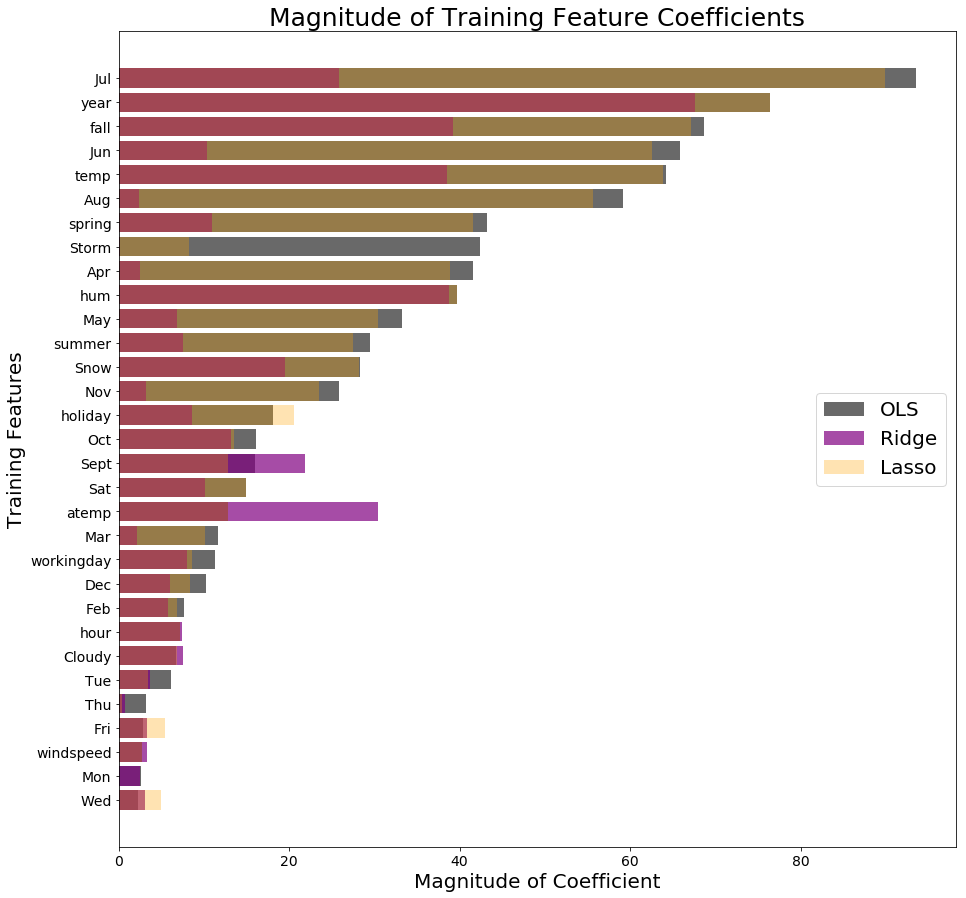

In [30]:
fig, ax = plt.subplots(1, 1, figsize = (15, 15))

keys_OLS = tuple(ordered_OLS.keys())
abs_values_OLS = [abs(x) for x in ordered_OLS.values()]
abs_values_RR = [abs(x) for x in RR_params_OLSorder.values()]
abs_values_LR = [abs(x) for x in LR_params_OLSorder.values()]

ax.barh(keys_OLS, abs_values_OLS, label = 'OLS', color = 'dimgrey')
ax.barh(keys_OLS, abs_values_RR, label = 'Ridge', color = 'purple', alpha = .7)
ax.barh(keys_OLS, abs_values_LR, label = 'Lasso', color = 'orange', alpha = .3)
ax.tick_params(labelsize = 14)
ax.set_ylabel('Training Features', fontsize = 20)
ax.set_xlabel('Magnitude of Coefficient', fontsize = 20)
ax.legend(loc = 'center right', fontsize = 20)
ax.set_title('Magnitude of Training Feature Coefficients', fontsize = 25)
plt.show()

#### 2.6 Let's examine a pair of features we believe to be related.  Is there a difference in the way Ridge and Lasso regression assign coefficients ...v

<HR>
Your answer here
<HR>

In [31]:
print('Ridge atemp: {0}, Lasso atemp: {1}'.format(BikeRRparams['atemp'], BikeLRparams['atemp']))
print('Ridge temp: {0}, Lasso temp: {1}'.format(BikeRRparams['temp'], BikeLRparams['temp']))

Ridge atemp: 30.384088629048826, Lasso atemp: 12.868397254893534
Ridge temp: 38.456208435774755, Lasso temp: 63.83086192823467


In [32]:
print(BikeRR_shrinkage_parameter)
print(BikeLR_shrinkage_parameter)

500
0.005


Yes, there is a difference in the way Ridge and Lasso assign coefficient to the predictors 'atemp' and 'temp'. Ridge weights 'temp' and 'atemp' more similarly (between the two predictors) than Lasso does. Lasso weighs 'temp' about 5 times heavier than 'atemp'. 

This is likely due to the large differences in their shrinkage parameters: Ridge's lambda = 500, while Lasso's lambda = 0.005. Increasing the value of lambda in a Ridge Regression tends to reduce the magnitude of the feature coefficients. So it makes sense that with such a large shrinkage parameter, we don't see such a high 'temp' coefficient as we do with Lasso regression.

#### 2.7.1 How do the estimated coefficients compare to or differ from ...

As can be seen in the bar graph above, the coefficients of all three models differ significantly. While July has the largest coefficient magnitude in both the OLS and the Lasso models, year has the largest coefficient magnitude in the Ridge model. Lasso appears to follow a similar trend in decreasing coefficient magnitude as the OLS model, apart from a deviation at 'Storm'. On the other hand, Ridge does not follow a similar pattern at all; the magnitudes of its coefficients are all over the place in the OLS ordering of coefficients.

#### 2.7.2 Is there a difference between coefficients estimated by the two shrinkage methods ...

Yes, there is a difference between the coefficients estimated by the two shrinkage methods. The shrinkage parameters for Lasso and Ridge are vastly different (0.005 and 500, respectively). The penalty in Lasso will force the coefficients to shrink closer to (and potentially become) zero, because it uses the sum of the absolutely values of the coefficients. On the other hand, the penalty in Ridge will decrease the coefficients' magnitude but will not eliminate the features (by making a coef = 0); this is because the penalty incoporates the sum of the squares of the coefficients (which is therefore small with coef < 0 and large with coef > 0). Since the shrinkage parameter for Ridge is so large, the majority of the feature coefficients are smaller than the corresponding coefficients found in the Lasso regression with a smaller shrinkage parameter.

#### 2.7.3 Is the significance related to the shrinkage in some way?

Yes, the significance is related to the shrinkage. Ridge's shrinkage parameter is much larger than Lasso's, therefore leading to coefficients with a smaller magnitude than Lasso's coefficients. See 2.7.2 for further explanation.

<div class='exercise'> <b> Question 3: Polynomial Features, Interaction Terms, and Cross Validation </b> </div>


We would like to fit a model to include all main effects and polynomial terms for numerical predictors up to the $4^{th}$ order. More precisely use the following terms: 
 - predictors in `X_train` and `X_test`
 - $X^1_j$, $X^2_j$, $X^3_j$, and $X^4_j$ for each numerical predictor $X_j$

**3.1** Create an expanded training set including all the desired terms mentioned above. Store that training set (as a pandas dataframe) in the variable `X_train_poly`.  Create the corresponding test set and store it as a pandas dataframe in `X_test_poly`.

**3.2** Discuss the following:

1. What are the dimensions of this 'design matrix' of all the predictor variables in 3.1?  
2. What issues may we run into attempting to fit a regression model using all of these predictors?

**3.3** Let's try fitting a regression model on all the predictors anyway.  Use the `LinearRegression` library from `sklearn` to fit a multiple linear regression model to the training set data in `X_train_poly`.  Store the fitted model in the variable `BikeOLSPolyModel`.

**3.4** Discuss the following:
1. What are the training and test $R^2$ scores? 
2. How does the model performance compare with the OLS model on the original set of features in Question 1?

**3.5** The training set $R^2$ score we generated for our model with polynomial and interaction terms doesn't have any error bars.  Let's use cross-validation to generate sample sets of $R^2$ for our model. Use 5-fold cross-validation to generate $R^2$ scores for the multiple linear regression model with polynomial terms.  What are the mean and standard deviation of the $R^2$ scores for your model.

**3.6** Visualize the $R^2$ scores generated from the 5-fold cross validation as a box and whisker plot.

**3.7** We've used cross-validation to generate error bars around our $R^2$ scores, but another use of cross-validation is as a way of model selection.  Let's construct the following model alternatives:

1. Multiple linear regression model generated based upon the feature set in Question 1 (let's call these the base features.
2. base features plus polynomial features to order 2
3. base features plus polynomial features to order 4

Use 5-fold cross validation on the training set to select the best model.  Make sure to evaluate all the models as much as possible on the same folds.  For each model generate a mean and standard deviation for the $R^2$ score.

**3.8** Visualize the $R^2$ scores generated for each model from 5-fold cross validation in box and whiskers plots.  Do the box and whisker plots influence your view of which model was best?

**3.9** Evaluate each of the model alternatives on the test set.  How do the results compare with the results from cross-validation?

### Answers

#### 3.1 Create an expanded training set including all the desired terms mentioned above. Store that training set (as a numpy array) in the variable `X_train_poly`....

In [33]:
# this is essentially from the solutions to HW3, #6
def higher_order_features(dataframe, feature_column, d) -> 'pandas dataframe':
    '''Take dataframe of features and return higher orders of continuous features
    Args:
        dataframe: pandas dataframe of features
        feature_column: string of column name
        d: degee of desired polynomial
    Returns: 
        pandas dataframe of higher order features up to and including the degree specified in the arguments,
        along with their respective feature names
    '''
    poly_model = PolynomialFeatures(d, include_bias = False)
    feature_data = dataframe[feature_column]
    
    higher_orders = poly_model.fit_transform(feature_data.values.reshape(-1,1))
    feature_names = poly_model.get_feature_names([feature_column])
    
    return pd.DataFrame(higher_orders[:,1:], columns = feature_names[1:])

In [34]:
test = X_train.reset_index(drop = True)
test.idxmax

<bound method DataFrame.idxmax of        hour  holiday  year  workingday      temp     atemp       hum  \
0         0        0     0           0 -1.332339 -1.090615  0.937108   
1         1        0     0           0 -1.436131 -1.179015  0.885320   
2         2        0     0           0 -1.436131 -1.179015  0.885320   
3         3        0     0           0 -1.332339 -1.090615  0.626377   
4         4        0     0           0 -1.332339 -1.090615  0.626377   
5         5        0     0           0 -1.332339 -1.266834  0.626377   
6         7        0     0           0 -1.539924 -1.266834  1.196051   
7         8        0     0           0 -1.332339 -1.090615  0.626377   
8        10        0     0           0 -0.605793 -0.474138  0.678165   
9        11        0     0           0 -0.709585 -0.826577  0.937108   
10       12        0     0           0 -0.398208 -0.297919  0.729954   
11       13        0     0           0 -0.190623 -0.121700  0.471011   
12       14        0     0    

In [35]:
def get_poly_dataset(training_df, test_df, d):
    '''Take original training and test datasets and return those datasets with added polynomial features
    Args: 
        training_df: pandas dataframe of training features
        test_df: pandas dataframe of test features
        d: degree of desired polynomial
    Returns:
        training df and test df with polynomial features up through degree 4
    '''
    continuous_columns = ['temp', 'atemp', 'hum', 'windspeed']

    higher_orders_train = [higher_order_features(training_df, feature, d) for feature in continuous_columns]
    higher_orders_test = [higher_order_features(test_df, feature, d) for feature in continuous_columns]

    higher_orders_train = pd.concat(higher_orders_train, axis = 1)
    higher_orders_test = pd.concat(higher_orders_test, axis = 1)

    higher_orders_column_names = higher_orders_train.columns

    # standardize higher order columns (I checked outside of the function and without scaling, 
    # these higher ordervariables aren't standardized, even though they are created off of standardized variables, 
    # which I don't quite understand. But I'm therefore scaling the higher order features)
    scaler = StandardScaler().fit(higher_orders_train)
    higher_orders_train[higher_orders_column_names] = scaler.transform(higher_orders_train)
    higher_orders_test[higher_orders_column_names] = scaler.transform(higher_orders_test)
    
    # reset X_train and X_test indices, so the dataframe join works appropriately
    X_train_reset = X_train.reset_index(drop = True)
    X_test_reset = X_test.reset_index(drop = True)
    
    X_poly_train = pd.concat([X_train_reset, higher_orders_train], axis = 1)
    X_poly_test = pd.concat([X_test_reset, higher_orders_test], axis = 1)
    
    return X_poly_train, X_poly_test   

In [36]:
X_poly_train, X_poly_test = get_poly_dataset(X_train, X_test, 4)

#### 3.2.1 What are the dimensions of this 'design matrix'...**

<HR>
Your answer here
<HR>

In [37]:
# for reference
print(X_train.shape)
print(X_test.shape)

(13903, 31)
(3476, 31)


In [38]:
print('Dimensions of polynomial training dataset: {}'.format(X_poly_train.shape))
print('Dimensions of polynomial test dataset: {}'.format(X_poly_test.shape))

Dimensions of polynomial training dataset: (13903, 43)
Dimensions of polynomial test dataset: (3476, 43)


Each of the polynomial datasets now has 43 predictors, which makes sense given that we added 3 higher order polynomials for 4 features. The polynomial contain the same number of observations as their original datasets (13903 for the training dataset, 3476 for the test dataset).

#### 3.2.2 What issues may we run into attempting to fit a regression model using all of these predictors? ...**

The continuous variables and their respective higher order polynomial variables will be highly correlated and all be dependent on the original continuous variable. Since we are not including interaction terms, we may overfit the regression model with all of these predictors.

#### 3.3 Let's try fitting a regression model on all the predictors anyway.  Use the `LinearRegression` library from `sklearn` to fit a multiple linear regression model ....

In [39]:
BikeOLSPolyModel = LinearRegression().fit(X_poly_train, y_train)

#### 3.4.1 What are the training and test $R^2$ scores?

In [40]:
pred_poly_train = BikeOLSPolyModel.predict(X_poly_train)
pred_poly_test = BikeOLSPolyModel.predict(X_poly_test)
r2_train_OLS_poly = r2_score(y_train, pred_poly_train)
r2_test_OLS_poly = r2_score(y_test, pred_poly_test)
print('Poly training R^2 score: {0:6f}'.format(r2_train_OLS_poly))
print('Poly test R^2 score: {0:6f}'.format(r2_test_OLS_poly))

Poly training R^2 score: 0.422308
Poly test R^2 score: 0.420279


In [41]:
BikePoly_r2scores = {'r2_training': r2_train_OLS_poly, 'r2_test': r2_test_OLS_poly}

In [42]:
BikePoly_r2scores['r2_test']

0.42027912762252395

In [43]:
print('Training R^2 score: {0:6f}'.format(BikeOLS_r2scores['r2_training']))
print('Test R^2 score: {0:6f}'.format(BikeOLS_r2scores['r2_test']))

Training R^2 score: 0.406539
Test R^2 score: 0.406386


#### 3.4.2 How does the model performance compare with the OLS model on the original set of features in Question 1?

The model's performance has improved when compared with the OLS model on the original set of features. The R^2 values for both the poly training and test sets have improved to ~0.42; on the original dataset, the were ~0.41.

#### 3.5 The training set $R^2$ score we generated for our model with polynomial and interaction terms doesn't have any error bars.  Let's use cross-validation to generate sample...

In [44]:
LinReg_object = LinearRegression()
cv_r2 = cross_val_score(LinReg_object, X_poly_train, y_train, cv = 5)
cv_r2

array([0.10950052, 0.3341185 , 0.21857369, 0.33524106, 0.3389565 ])

In [45]:
print('The mean of the R^2 scores is: {}'.format(np.mean(cv_r2)))
print('The standard deviation of the R^2 scores is: {}'.format(np.std(cv_r2)))

The mean of the R^2 scores is: 0.26727805322296977
The standard deviation of the R^2 scores is: 0.09109366555046658


#### 3.6 Visualize the $R^2$ scores generated from the 5-fold cross validation as a box and whisker plot.

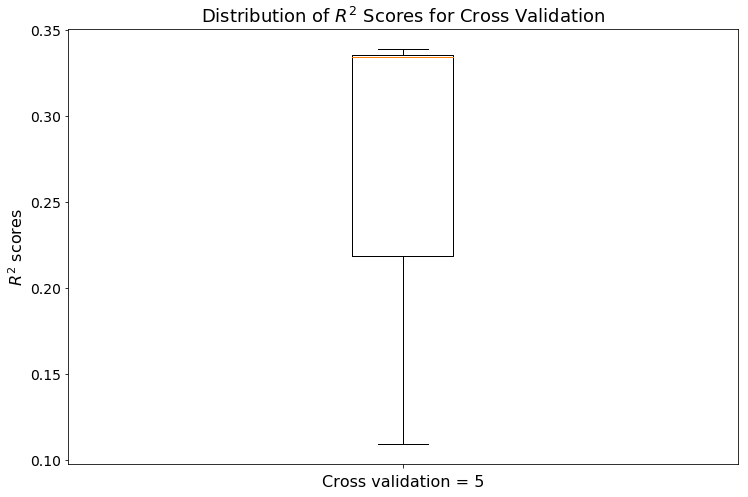

In [46]:
fig, ax = plt.subplots(1, 1, figsize = (12, 8))

ax.boxplot(cv_r2)
ax.set_xticklabels([])
ax.tick_params(labelsize = 14)
ax.set_ylabel('$R^{2}$ scores', fontsize = 16)
ax.set_xlabel('Cross validation = 5', fontsize = 16)
ax.set_title(r'Distribution of $R^{2}$ Scores for Cross Validation', fontsize = 18)

plt.show()

#### 3.7 We've used cross-validation to generate error bars around our $R^2$ scores, but another use of cross-validation is as a way of model selection.  Let's construct the following model alternatives ...

In [47]:
def compute_r2(Xtrain, Ytrain, Xvalid, Yvalid):
    '''Take training and validation sets and return R^2 scores for training and validation data
    Args:
        Xtrain and Ytrain: feature and target training datasets, respectively
        Xvalid and Yvalid: feature and target validation datasets, respectively
    Returns:
        R^2 scores for the training data and the validation data
    '''
    lreg = LinearRegression()
    lreg.fit(Xtrain, Ytrain)
    predict_train = lreg.predict(Xtrain)
    predict_valid = lreg.predict(Xvalid)
    train_r2 = r2_score(Ytrain, predict_train)
    valid_r2 = r2_score(Yvalid, predict_valid)

    return train_r2, valid_r2

In [48]:
def r2_cross_val(Xtrain, Ytrain):
    '''Take training data and return R^2 scores for training and validation sets, with 5-fold cross-validation
    Args:
        Xtrain and Ytrain: feature and target training datasets, respectively
    Returns:
        5-fold cross-validation R^2 scores on training and validation data
    '''
    fold = 0
    train_r2_cv = np.zeros(5)
    valid_r2_cv = np.zeros(5)
    for train, valid in KFold(5, random_state = 42).split(range(len(Xtrain))): 
        train_set = Xtrain.iloc[train]
        valid_set = Xtrain.iloc[valid]
        # Compute R^2 at each fold
        train_r2_cv[fold], valid_r2_cv[fold] = compute_r2(train_set, Ytrain[train], valid_set, Ytrain[valid])
        fold += 1
    return train_r2_cv, valid_r2_cv

In [49]:
OLS_train_r2, OLS_valid_r2 = r2_cross_val(X_train, y_train)
mean_train_OLS_r2 = np.mean(OLS_train_r2)
mean_valid_OLS_r2 = np.mean(OLS_valid_r2)
std_train_OLS_r2 = np.std(OLS_train_r2)
std_valid_OLS_r2 = np.std(OLS_valid_r2)
print('OLS training R^2 score: mean = {0} and std = {1}'.format(mean_train_OLS_r2, std_train_OLS_r2))
print('OLS validation R^2 score: mean = {0} and std = {1}'.format(mean_valid_OLS_r2, std_valid_OLS_r2))

OLS training R^2 score: mean = 0.40565701448951524 and std = 0.010139840622957709
OLS validation R^2 score: mean = 0.2579944364362185 and std = 0.0922005509622769


In [50]:
X_poly2_train, X_poly2_test = get_poly_dataset(X_train, X_test, 2)
poly2_train_r2, poly2_valid_r2 = r2_cross_val(X_poly2_train, y_train)
mean_train_poly2_r2 = np.mean(poly2_train_r2)
mean_valid_poly2_r2 = np.mean(poly2_valid_r2)
std_train_poly2_r2 = np.std(poly2_train_r2)
std_valid_poly2_r2 = np.std(poly2_valid_r2)
print('Poly of degree 2 training R^2 score: mean = {0} and std = {1}'.format(mean_train_poly2_r2, std_train_poly2_r2))
print('Poly of degree 2 validation R^2 score: mean = {0} and std = {1}'.format(mean_valid_poly2_r2, 
                                                                             std_valid_poly2_r2))

Poly of degree 2 training R^2 score: mean = 0.4114681021195823 and std = 0.011389850641179188
Poly of degree 2 validation R^2 score: mean = 0.263258751169427 and std = 0.07670352483743688


In [51]:
poly4_train_r2, poly4_valid_r2 = r2_cross_val(X_poly_train, y_train)
mean_train_poly4_r2 = np.mean(poly4_train_r2)
mean_valid_poly4_r2 = np.mean(poly4_valid_r2)
std_train_poly4_r2 = np.std(poly4_train_r2)
std_valid_poly4_r2 = np.std(poly4_valid_r2)
print('Poly of degree 4 training R^2 score: mean = {0} and std = {1}'.format(mean_train_poly4_r2, std_train_poly4_r2))
print('Poly of degree 4 validation R^2 score: mean = {0} and std = {1}'.format(mean_valid_poly4_r2, 
                                                                             std_valid_poly4_r2))

Poly of degree 4 training R^2 score: mean = 0.42208134233002925 and std = 0.01115583652768066
Poly of degree 4 validation R^2 score: mean = 0.26727805322296977 and std = 0.09109366555046658


The model with the highest mean R^2 score on the validation is the polynomial of degree 4 (score = 0.2673). Because of this, the polynomial of degree 4 is a slightly better model than the polynomial of degree 2 and the OLS model (scores of 0.2633 and 0.2580, respectively).

#### 3.8 Visualize the $R^2$ scores generated for each model from 5-fold cross validation in box and whiskers plots.  Do the box and whisker plots influence your view of which model was best? ...

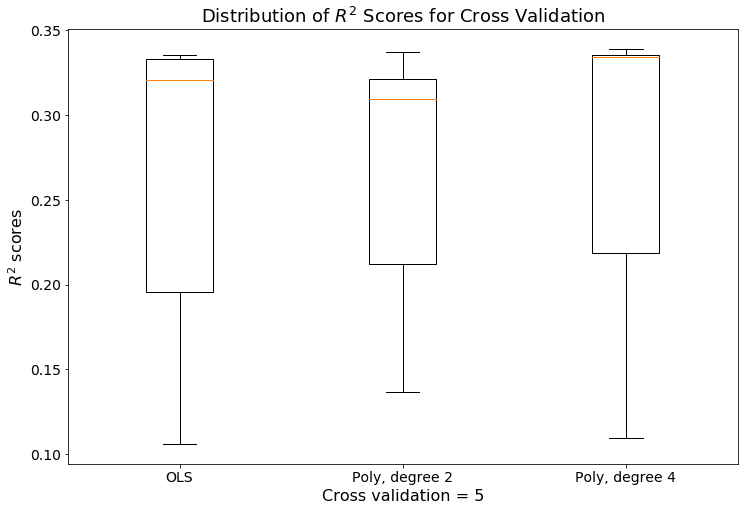

In [52]:
cv_r2_list = [OLS_valid_r2, poly2_valid_r2, poly4_valid_r2]
labels = ['OLS', 'Poly, degree 2', 'Poly, degree 4']

fig, ax = plt.subplots(1, 1, figsize = (12, 8))

ax.boxplot(cv_r2_list)
ax.set_xticklabels(labels)
ax.tick_params(labelsize = 14)
ax.set_ylabel('$R^{2}$ scores', fontsize = 16)
ax.set_xlabel('Cross validation = 5', fontsize = 16)
ax.set_title(r'Distribution of $R^{2}$ Scores for Cross Validation', fontsize = 18)

plt.show()


In [53]:
lower_quart_poly4, upper_quart_poly4 = np.percentile(poly4_valid_r2, [25, 75])
lower_quart_poly2, upper_quart_poly2 = np.percentile(poly2_valid_r2, [25, 75])
lower_quart_OLS, upper_quart_OLS = np.percentile(OLS_valid_r2, [25, 75])
print('Polynomial of degree four: Q1 = {0}, Q3 = {1}'.format(lower_quart_poly4, upper_quart_poly4))
print('Polynomial of degree two: Q1 = {0}, Q3 = {1}'.format(lower_quart_poly2, upper_quart_poly2))
print('OLS: Q1 = {0}, Q3 = {1}'.format(lower_quart_OLS, upper_quart_OLS))

Polynomial of degree four: Q1 = 0.218573688866458, Q3 = 0.3352410584506209
Polynomial of degree two: Q1 = 0.2122294421447648, Q3 = 0.32103556507836917
OLS: Q1 = 0.1953169093472884, Q3 = 0.3331346052054591


While the polynomial of degree 2 has a higher minimum and maximum than the OLS and poly of degree 4 models, it's median is lower than the other two models. Polynomial of degree 4 has the highest median of all three. Polynomial of degree 4 also has both the highest lower quartile and highest upper quartile across all three models. Because of this, I'm more convinced that the polynomial of degree 4 is the best model.

#### 3.9 Evaluate each of the model alternatives on the  test set.  How do the results compare with the results from cross-validation?

In [54]:
poly2_model = LinearRegression().fit(X_poly2_train, y_train)
predict_test = poly2_model.predict(X_poly2_test)
poly2_test_r2 = r2_score(y_test, predict_test)

In [55]:
print('OLS test R^2 score: {0:6f}'.format(BikeOLS_r2scores['r2_test'])) # from part 3.4.1
print('Poly of degree 2 test R^2 score: {0:6f}'.format(poly2_test_r2))
print('Poly of degree 4 test R^2 score: {0:6f}'.format(BikePoly_r2scores['r2_test'])) # from part 3.4.1

OLS test R^2 score: 0.406386
Poly of degree 2 test R^2 score: 0.410760
Poly of degree 4 test R^2 score: 0.420279


These results confirm the best model chosen in 3.7 and 3.8: polynomial of degree 4. This model's R^2 score on the test set is the highest out of all three models. 